# # 交通流量分析
# 使用YOLO和OpenCV实现视频中车辆流量的计算


### 1. 导入必要的库

In [2]:
import cv2
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/chenwuyi/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
class Car:
    def __init__(self, bbox, frame):
        """
        初始化车辆对象
        bbox: [x1, y1, x2, y2] 边界框坐标
        frame: 当前帧图像
        """
        self.bbox = bbox
        # 计算中心点坐标
        self.x = (bbox[0] + bbox[2]) / 2
        self.y = (bbox[1] + bbox[3]) / 2
        # 截取车辆图像区域
        self.img = self.crop_car(frame)
        
    def crop_car(self, frame):
        """截取车辆图像区域"""
        x1, y1, x2, y2 = map(int, self.bbox)
        return frame[y1:y2, x1:x2]
    
    def calculate_color_histogram(self):
        """计算颜色直方图"""
        # 转换为灰度图
        gray = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        # 计算直方图
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
        # 归一化
        cv2.normalize(hist, hist)
        return hist
    
    def compare_with_car(self, other_car):
        """
        与另一辆车进行比较，返回相似度分数
        分数越小表示越相似
        """
        # 计算位置距离
        pos_diff = np.sqrt((self.x - other_car.x)**2 + (self.y - other_car.y)**2)
        
        # 计算直方图差异
        hist1 = self.calculate_color_histogram()
        hist2 = other_car.calculate_color_histogram()
        hist_diff = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CHISQR)
        
        # 综合评分 (可以调整权重)
        return 0.3 * pos_diff + 0.7 * hist_diff

In [4]:
def process_video(video_path, detection_zone=None, skip_frames=2):
    """
    处理视频并计算车流量
    video_path: 视频文件路径
    detection_zone: 检测区域 [y_min, y_max]
    skip_frames: 跳帧数
    """
    # 初始化
    model = YOLO('yolov8n.pt')  # 加载YOLO模型
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    car_count = 0
    previous_cars = []
    
    # 设置检测区域
    if detection_zone is None:
        ret, first_frame = cap.read()
        if ret:
            height = first_frame.shape[0]
            detection_zone = [int(height*0.4), int(height*0.6)]
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    
    # 主循环
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
            
        frame_count += 1
        if frame_count % skip_frames != 0:  # 跳帧处理
            continue
            
        # 目标检测
        results = model(frame)[0]
        current_cars = []
        
        # 处理检测结果
        for box in results.boxes.data:
            x1, y1, x2, y2, conf, cls = box
            
            # 只处理车辆类别且在检测区域内的目标
            if cls == 2 and detection_zone[0] <= (y1+y2)/2 <= detection_zone[1]:  # 2是车辆类别
                car = Car([x1, y1, x2, y2], frame)
                current_cars.append(car)
        
        # 车辆匹配和计数
        for car in current_cars:
            is_new_car = True
            for prev_car in previous_cars:
                if car.compare_with_car(prev_car) < 50:  # 阈值可调
                    is_new_car = False
                    break
            if is_new_car:
                car_count += 1
        
        previous_cars = current_cars
        
        # 显示检测结果
        if frame_count % 10 == 0:  # 每10帧更新一次显示
            # 画出检测区域
            cv2.line(frame, (0, detection_zone[0]), (frame.shape[1], detection_zone[0]), (0,255,0), 2)
            cv2.line(frame, (0, detection_zone[1]), (frame.shape[1], detection_zone[1]), (0,255,0), 2)
            
            # 显示车辆数量
            cv2.putText(frame, f'Cars: {car_count}', (50,50), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
            
            # 显示边界框
            for car in current_cars:
                x1, y1, x2, y2 = map(int, car.bbox)
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)
            
            # 显示结果
            clear_output(wait=True)
            plt.figure(figsize=(10,6))
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()
    
    cap.release()
    return car_count

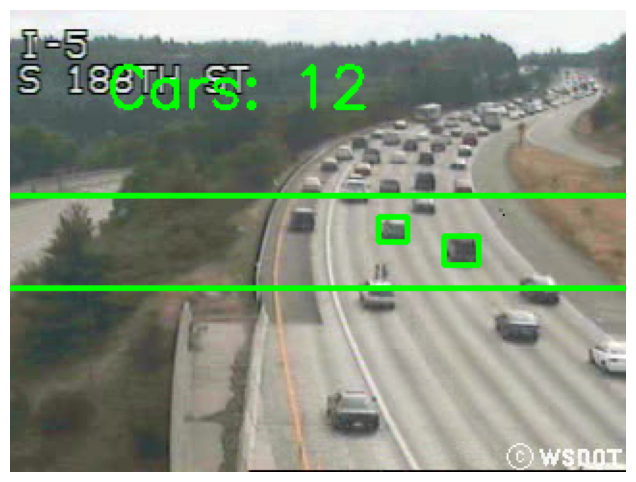


0: 480x640 9 cars, 1 bus, 67.3ms
Speed: 2.1ms preprocess, 67.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 9 cars, 46.2ms
Speed: 1.8ms preprocess, 46.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 10 cars, 1 bus, 1 truck, 41.3ms
Speed: 1.3ms preprocess, 41.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 11 cars, 1 bus, 41.8ms
Speed: 1.1ms preprocess, 41.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)
Total cars detected: 12


In [5]:
# 处理视频
video_path = "/Users/chenwuyi/Developer/SuperD/Videos/cctv052x2004080516x01640.avi"  # 你的视频文件路径
total_cars = process_video(video_path)
print(f"Total cars detected: {total_cars}")